# Learn from cleanrl implementation

https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/dqn.py

# import

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid
import pickle
from tqdm import tqdm


from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv, 
    EpisodicLifeEnv, #make end of life = end of episode
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv
)

from stable_baselines3.common.buffers import ReplayBuffer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42

#seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hyperparams

In [2]:
ENV_ARGS = {
    'id': 'AssaultNoFrameskip-v0'
}

ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', ENV_ARGS['id'])

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

NUM_ENVS = 3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", DEVICE)

device =  cpu


# env wrapper

In [3]:
def make_env(**env_args):
    env = gym.make(**env_args)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env)
    env = MaxAndSkipEnv(env)
    env = EpisodicLifeEnv(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)

    return env

# Replay buffer

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory():
    def __init__(self, capacity, device = 'cpu') -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
        self.device = device
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        '''
        @params: 
            batch_size: int
        @return:
            states: torch.tensor
            actions: torch.tensor
            rewards: torch.tensor
            next_states: torch.tensor
            done: torch.tensor
        '''
        if batch_size > len(self.memory): return None
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        device = self.device

        state_batch = torch.tensor(batch.state).float().to(device)
        next_state_batch = torch.tensor(batch.next_state).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).float().to(device)

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

# Qnetwork

In [5]:
class QNetwork(nn.Module):
    def __init__(self, envs: gym.Env):

        super().__init__()

        self.state_shape = np.prod(envs.single_observation_space.shape)
        self.action_shape = np.prod(envs.single_action_space.n)

        self.network = nn.Sequential(
            nn.LazyConv2d(32, 8, stride = 4),
            nn.ReLU(),
            nn.LazyConv2d(64, 4, stride = 2),
            nn.ReLU(),
            nn.LazyConv2d(64, 3, stride = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.LazyLinear(self.action_shape),
        )

    def forward(self, x):
        return self.network(x/255.0)


In [6]:
# Test running network on env

# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
) 

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

obs, info = envs.reset()
obs = torch.tensor(obs)
print('observation shape = ', obs.shape)
print('observation shape = ', envs.single_action_space.n)

qnet = QNetwork(envs)

action = qnet(obs)

print('action shape = ', action.shape)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


observation shape =  torch.Size([3, 4, 84, 84])
observation shape =  7
action shape =  torch.Size([3, 7])


/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Epsilone decay function

In [7]:
def linear_schedule(start_e: int, end_e:int , total_t:int , t:int ):
    # epsilone value decays linear
    slope = (end_e - start_e) / total_t
    return max(slope * t + start_e, end_e)

def plot_schedule(function, start_e, end_e, duration, explore_fraction = 1.0):
    #  explore for some time, then only exploit (epsilon stays at end_e)
    data = []

    for t in range(duration):
        v = function(start_e, end_e, int(explore_fraction * duration), t)
        data.append(v)
    
    sns.lineplot(y = data, x = list(range(len(data))))
    plt.title('schedule plot')
    plt.show()

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

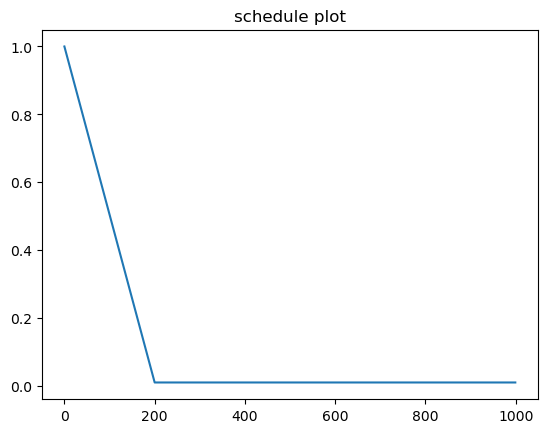

In [8]:
# Test
plot_schedule(linear_schedule, 1.0, 0.01, 1000, 0.2)

# Training loop

In [11]:
def tune(envs, policy_net, target_net, optimizer, start_ep, end_ep, gamma,
    explore_fraction = 0.3, 
    buffer_size=int(1e6), batch_size = 32,
    total_timesteps = int(10e6), warmup_steps = 5000, skip_steps = 4,
    device = DEVICE, plot_update_freq = 50, label = 'baseline'):

    observation_space = envs.single_observation_space
    action_space = envs.single_action_space
    n_envs = envs.observation_space.shape[0]

    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    print('save path = ', SAVE_PATH)

    replay_buffer = ReplayBuffer(
        buffer_size,
        observation_space,
        action_space,
        device,
        n_envs=n_envs,
        optimize_memory_usage=True,
        handle_timeout_termination=False
    )

    obs, _ = envs.reset()
    loop = tqdm(range(total_timesteps))

    score_window = deque(maxlen=100)
    history = defaultdict(list)

    for global_step in loop:


        epsilon = linear_schedule(start_ep, end_ep, int( explore_fraction *  total_timesteps), global_step)

        #greedy epsilon 
        p = random.random()

        if epsilon > p:
            #explore
            actions = np.array([envs.single_action_space.sample() for _ in range(n_envs)])
        else:
            action_pred = policy_net(torch.tensor(obs).to(device)) 
            actions = torch.argmax(action_pred, dim = 1).cpu().numpy()
        
        # print('actions = ', actions.shape)
        
        next_obs, rewards, terminated, truncated, infos = envs.step(actions)
        # print('next obs =', next_obs.shape)
        # print('rewards obs =', rewards.shape)
        # print('terminated obs =', terminated.shape)
        # print('truncated obs =', truncated.shape)

        if 'final_info' in infos:
            for k,v in infos.items():
                for info in infos['final_info']:
                    if info and 'episode' in info:
                        ep_return = info['episode']['r']
                        score_window.append(ep_return)
                        avg_reward = np.mean(score_window)
                        history['reward'].append(avg_reward)
        
        #save transition to replay buffer
        real_next_obs = next_obs.copy()
        for idx, trunc in enumerate(truncated):
            if trunc:
                real_next_obs[idx] = infos["final_observation"][idx]
        
        replay_buffer.add(obs, real_next_obs, actions, rewards, terminated, infos)

        obs = next_obs

        #training with DQN algorithm
        if global_step > warmup_steps:
            if global_step % skip_steps == 0:
                b_obs, b_actions, b_next_obs, b_dones, b_rewards = replay_buffer.sample(batch_size)

                # print('b obs = ', b_obs.shape)
                # print('b actions = ', b_actions.shape)
                # print('b next_obs = ', b_next_obs.shape)
                # print('b dones = ', b_dones.shape)
                # print('b rewards = ', b_rewards.shape)

                with torch.no_grad():
                    target_value = target_net(b_next_obs).max(1).values
                    td_target = b_rewards.flatten() + gamma * target_value * (1 - b_dones.flatten())
                
                old_value = policy_net(b_obs).gather(1, b_actions).squeeze()

                loss = F.mse_loss(old_value, target_value)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            if global_step % plot_update_freq == 0: 
                plot(history, save_path = FIG_SAVE_PATH)
        

        loop.set_description(f"epsilon = {epsilon:.2f}, avg_reward = {np.mean(score_window):.2f}, episodes = {len(history['reward'])}")
    
    plot(history, show = True, save_path = FIG_SAVE_PATH)
    
    with open(os.path.join(SAVE_PATH, 'history.pickle'), 'wb') as file:
        pickle.dump(history, file)


In [12]:
#parameters
lr = 1e-4
start_ep = 1.0
end_ep = 0.01
total_timesteps = int(1e7)
device = DEVICE
gamma = 0.99
plot_update_freq =100

# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(2)]
) 

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

obs, info = envs.reset()
obs = torch.tensor(obs)
print('observation shape = ', obs.shape)
print('observation shape = ', envs.single_action_space.n)

policy_net = QNetwork(envs).to(device)
target_net = QNetwork(envs).to(device)

optimizer = torch.optim.Adam(policy_net.parameters(), lr = lr)

tune(envs, policy_net, target_net, optimizer, 
start_ep = start_ep, end_ep = end_ep, gamma= gamma,
device = device, total_timesteps=total_timesteps, plot_update_freq= plot_update_freq)





/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 28.24GB > 1.62GB
  warnings.warn(


observation shape =  torch.Size([2, 4, 84, 84])
observation shape =  7
save path =  /Volumes/SanDisk/NLP_RNN/Reinforcement Learning/deep rl/dqn/output/AssaultNoFrameskip-v0/baseline


epsilon = 0.98, avg_reward = 273.00, episodes = 1794:   1%|          | 51908/10000000 [18:23<58:46:07, 47.02it/s] 


KeyboardInterrupt: 